# Assignment 5

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* Please note that in this assignment, students are expected to work independently. As a result, no two solutions should look identical in terms of coding.
---

``Objective``
* Perform multiclass classification using logistic regression. <span style="color:chocolate"> You will choose the outcome of interest. </span>

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task.


``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [1]:
%reset -f  # Clears all variables from the memory of the interactive namespace, ensuring a clean environment.

from __future__ import print_function  # Allows the use of the print function from Python 3 in Python 2.

import math  # Imports the math module, which provides access to mathematical functions like sqrt, sin, cos, etc.

import numpy as np  # Imports the numpy module, a fundamental package for numerical computation in Python, and aliases it as 'np'.

import numpy.linalg as nla  # Imports the linear algebra sub-module from numpy for operations like matrix inversion and solving linear systems, and aliases it as 'nla'.

import pandas as pd  # Imports the pandas module, which offers data structures and operations for manipulating numerical tables and time series, and aliases it as 'pd'.

import re  # Imports the re module, which allows you to perform regular expression operations for complex string processing.

import six  # Imports the six module, providing utilities for writing code compatible with both Python 2 and Python 3.

from os.path import join  # Imports the join function from the os.path module, which is used to concatenate paths in an OS-independent way.

from matplotlib import pyplot as plt  # Imports the pyplot interface of the matplotlib library for plotting graphs and visualizing data, aliasing it as 'plt'.

import seaborn as sns  # Imports the seaborn library for making statistical graphics, built on top of matplotlib, and aliases it as 'sns'.

from sklearn.model_selection import train_test_split  # Imports the train_test_split function from scikit-learn for splitting data into training and testing sets.

from sklearn.metrics import accuracy_score  # Imports the accuracy_score function from scikit-learn for calculating the accuracy of a model.

from sklearn.preprocessing import LabelEncoder  # Imports the LabelEncoder class from scikit-learn for encoding categorical labels as numeric values.

from tensorflow.keras.models import Sequential  # Imports the Sequential class from TensorFlow Keras for creating neural network models in a linear stack.

from tensorflow.keras.layers import Dense, Dropout  # Imports the Dense and Dropout layers from TensorFlow Keras for creating fully connected layers and dropout layers in neural networks.

from tensorflow.keras.optimizers import Adam, SGD  # Imports the Adam and SGD optimizers from TensorFlow Keras for optimizing the training of neural networks.

from tensorflow.keras.regularizers import l2  # Imports the l2 regularizer from TensorFlow Keras for adding L2 regularization to layers to prevent overfitting.

Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  all, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Don't know how to reset  from, please run `%reset?` for details
Don't know how to reset  the, please run `%reset?` for details
Don't know how to reset  memory, please run `%reset?` for details
Don't know how to reset  of, please run `%reset?` for details
Don't know how to reset  the, please run `%reset?` for details
Don't know how to reset  interactive, please run `%reset?` for details
Don't know how to reset  namespace,, please run `%reset?` for details
Don't know how to reset  ensuring, please run `%reset?` for details
Don't know how to reset  a, please run `%reset?` for details
Don't know how to reset  clean, please run `%reset?` for details
Don't know how to reset  environment., please run `%reset?` for details


We import these libraies so that we do not have to individually code their functions

### Define functions

In [ ]:
def read_data():
    ''''''
    # This function reads a CSV file from a specified URL and returns a pandas DataFrame.

    # Read data: the function uses pandas' read_csv method to load data from a URL.
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",  # URL where the CSV file is located.
        sep=",",  # Specifies that the fields in the CSV are separated by commas.
        encoding='latin-1'  # Specifies the encoding type of the CSV file. 'latin-1' helps in handling special characters.
    )

    # Return the DataFrame containing the data read from the CSV file.
    return df

Function that will read the flavors_of_cacao csv and store it in a pandas df

In [ ]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15

    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

Function that sanitizes the data we just stored into our data frame

---
### Step 1: Data ingestion

First, we'll initiate the process of discovering the chocolate world by loading the data. Then, to assist with this assignment, we'll start by tidying up the data a little bit. This involves renaming columns and conducting some string preprocessing tasks, which will be handled by the <span style="color:chocolate">clean_data()</span> function mentioned earlier.

In [ ]:
# Function that reads data from a source (e.g., a CSV file, database, etc.)
df = clean_data(read_data())

# Print the shape of the DataFrame to understand the number of rows and columns
print('Shape of data', df.shape)

# Display the first few rows of the DataFrame to get an overview of the data
df.head()

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


We called our clean_data function and passed in our read_data function, this will store the flavors_of_cacao cvs in a dataframe then format its values to the proper format for data exploration/manipulation. We then output the newly created data frame, first five rows; which included the following columns:

*   maker	specific_origin	reference_number	review_date	cocoa_percent	maker_location	rating	bean_type	broad_origin





### <span style="color:chocolate">Exercise 1:</span> Getting to know the data (5 points)

Answer the following questions:
    
1. How many columns does the dataset contain?
2. How many rows are there in the dataset?
3. What are the column names?
4. List the number of unique values for each column in the data;
5. What do the reference and rating numbers represent? (Hint: read the dataset documentation and write down the interpretation for each number).

In [ ]:
# Print the number of columns in the dataset
print(f"The dataset contains {df.shape[1]} columns")

# Print the number of rows in the dataset
print(f"The dataset contains {df.shape[0]} rows")

# Join the column names into a single string separated by spaces
col_names = ' '.join(df.columns)

# Print the column names
print(f"The column names are: \n{col_names}")

# Print the unique values for each column
print("The number of unique values for each column are:\n")
for col in df.columns:
    print(f"{col}: {df[col].unique()}\n")

# Print explanation of the reference number
print(f"\nThe reference number acts as a unique identifier for each chocolate bar review.")

# Print explanation of the rating number
print(f"\nThe rating number provides a summary judgment of the chocolate bar’s overall quality based on expert evaluations.")
print("1: Poor quality\n2: Below average\n3: Average\n4: Above average\n5: Excellent quality")

The dataset contains 9 columns
The dataset contains 1795 rows
The column names are: 
maker specific_origin reference_number review_date cocoa_percent maker_location rating bean_type broad_origin
The number of unique values for each column are:

maker: 414

specific_origin: 1038

reference_number: 440

review_date: 12

cocoa_percent: 45

maker_location: 58

rating: 13

bean_type: 39

broad_origin: 160

The number of unique values for each column are:

maker: ['A. Morin' 'Acalli' 'Adi' 'Aequare (Gianduja)' 'Ah Cacao'
 "Akesson's (Pralus)" 'Alain Ducasse' 'Alexandre' 'Altus aka Cao Artisan'
 'Amano' 'Amatller (Simon Coll)' 'Amazona' 'Ambrosia' 'Amedei' 'AMMA'
 'Anahata' 'Animas' 'Ara' 'Arete' 'Artisan du Chocolat'
 'Artisan du Chocolat (Casa Luker)' 'Askinosie' 'Bahen & Co.' 'Bakau'
 'Bar Au Chocolat' "Baravelli's" 'Batch' 'Beau Cacao' 'Beehive'
 'Belcolade' 'Bellflower' 'Belyzium' 'Benoit Nihant' 'Bernachon'
 'Beschle (Felchlin)' 'Bisou' 'Bittersweet Origins' 'Black Mountain'
 'Black Riv

We then printed the number of columns in the dataset by using pandas shape method, putting a [1] after shape tells the computer that we want the colums (0 is for rows 1 is for columns). We repeated this step to find the number of rows aswell. Next we prited out the name of the columns and each columns unique value. This gives an idea of all the classes and features we have at our disposal.

### <span style="color:chocolate">Exercise 2:</span> Choosing the prediction task (5 points)

Now that you've familiarized yourself with the data a little bit, select a multiclass outcome you're interested in predicting. Note: the outcome should have <span style="color:chocolate">at least 3 classes</span>!

Intuition: conducting a multi-class classification on this chocolate dataset can be incredibly valuable for several reasons: customer preferences and personalization, market analysis, R&D, etc.

My Choice:

  Outcome: Bean Type Classification: Predict the type of bean used (e.g., Criollo, Forastero, Trinitario).
  
  Classes: Criollo: 'Criollo', 'Criollo (Porcelana)', 'Criollo (Ocumare)', 'Criollo (Ocumare 61)', 'Criollo (Ocumare 77)', 'Criollo (Ocumare 67)', 'Criollo (Wild)', 'Criollo (Amarru)', 'Criollo, Trinitario'
Forastero: 'Forastero', 'Forastero (Arriba)', 'Forastero (Nacional)', 'Forastero (Catongo)', 'Forastero (Parazinho)', 'CCN51', 'Forastero (Arriba) ASS', 'Forastero (Arriba) ASSS', 'Forastero(Arriba, CCN)', 'Forastero (Amelonado)'
Trinitario: 'Trinitario', 'Trinitario (85% Criollo)', 'Trinitario (Scavina)', 'Trinitario, Forastero', 'Forastero, Trinitario', 'Trinitario, Nacional', 'Trinitario (Amelonado)', 'Trinitario, TCGA'
Blend: 'Blend', 'Blend-Forastero,Criollo', 'Amazon mix', 'Criollo, +', 'Amazon', 'Amazon, ICS', 'EET', 'Matina', 'Nacional', 'Beniano', 'Nacional (Arriba)'
  
  Value: By predicting the type of bean, we can gain insights into the characteristics and quality of different chocolates, as the type of bean significantly impacts flavor and quality

---
### Step 2: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 3:</span> Plots (20 points)

In line with the structure of previous assignments, execute the following steps:

1. Generate a minimum of 4 plots to investigate features within the dataset and the chosen outcome;
2. Ensure that each plot includes clear axis labels and titles;
3. Provide commentary on the insights learned from your visualizations.

We then explored the data to see if we could find any insights such as relationships, correlations, etc. This included creating plots to help us vizualize the data. In our findings we noticed that:

*   ONLY 5 rated chocolate is 70% cocoa
*   The majority of chocolate is between 50% - 90% cocoa
*   100% cocoa does not get a rating higher than 3.5
*   Venezuela has the most reviews
*   South American countries like Venezuela, Ecuador, and Peru are highly represented, indicating their importance in the chocolate







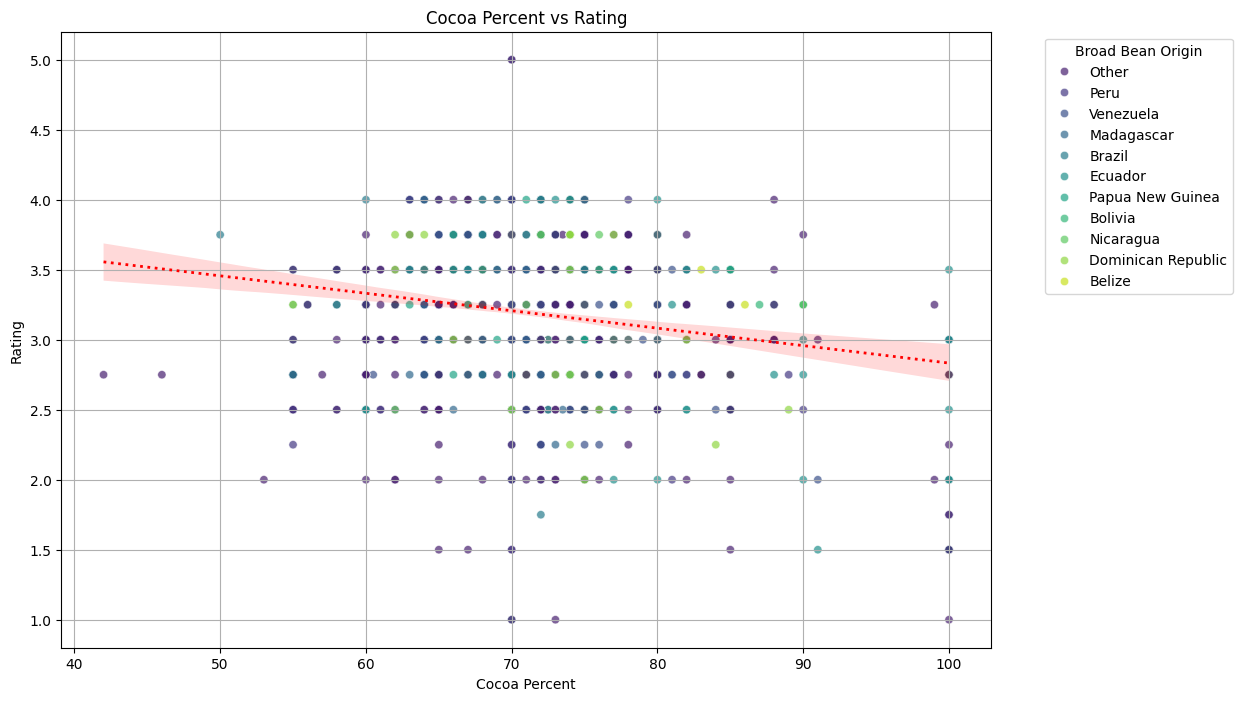

In [ ]:
# Cocoa Percent vs. Rating
# Combine less common origins into 'Other' category
# Get the top 10 most common broad origins
top_origins = df['broad_origin'].value_counts().index[:10]

# Apply a function to the 'broad_origin' column that keeps the origin if it's in the top 10, otherwise sets it to 'Other'
df['broad_origin'] = df['broad_origin'].apply(lambda x: x if x in top_origins else 'Other')

# Improved Plot
plt.figure(figsize=(12, 8))  # Set the figure size for the plot

# Create a scatter plot of cocoa percent vs. rating, with points colored by broad origin
sns.scatterplot(x='cocoa_percent', y='rating', hue='broad_origin', palette='viridis', data=df, alpha=0.7)

# Add a trend line to the scatter plot, without showing the scatter points again
sns.regplot(x='cocoa_percent', y='rating', data=df, scatter=False, color='red', line_kws={"lw":2, "ls":":"})

# Set the x-axis label
plt.xlabel('Cocoa Percent')

# Set the y-axis label
plt.ylabel('Rating')

# Set the title of the plot
plt.title('Cocoa Percent vs Rating')

# Adjust the legend title and position it outside the plot
plt.legend(title='Broad Bean Origin', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add gridlines to the plot for better readability
plt.grid(True)

# Show the plot
plt.show()

Insights:

*   Looks like the ONLY 5 rated chocolate is 70% cocoa
*   The majority of chocolate is between 50% - 90% cocoa
*   100% cocoa does not get a rating higher than 3.5

  
  

<ipython-input-191-ca30cb2d123a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='broad_origin', palette='viridis', data=df)


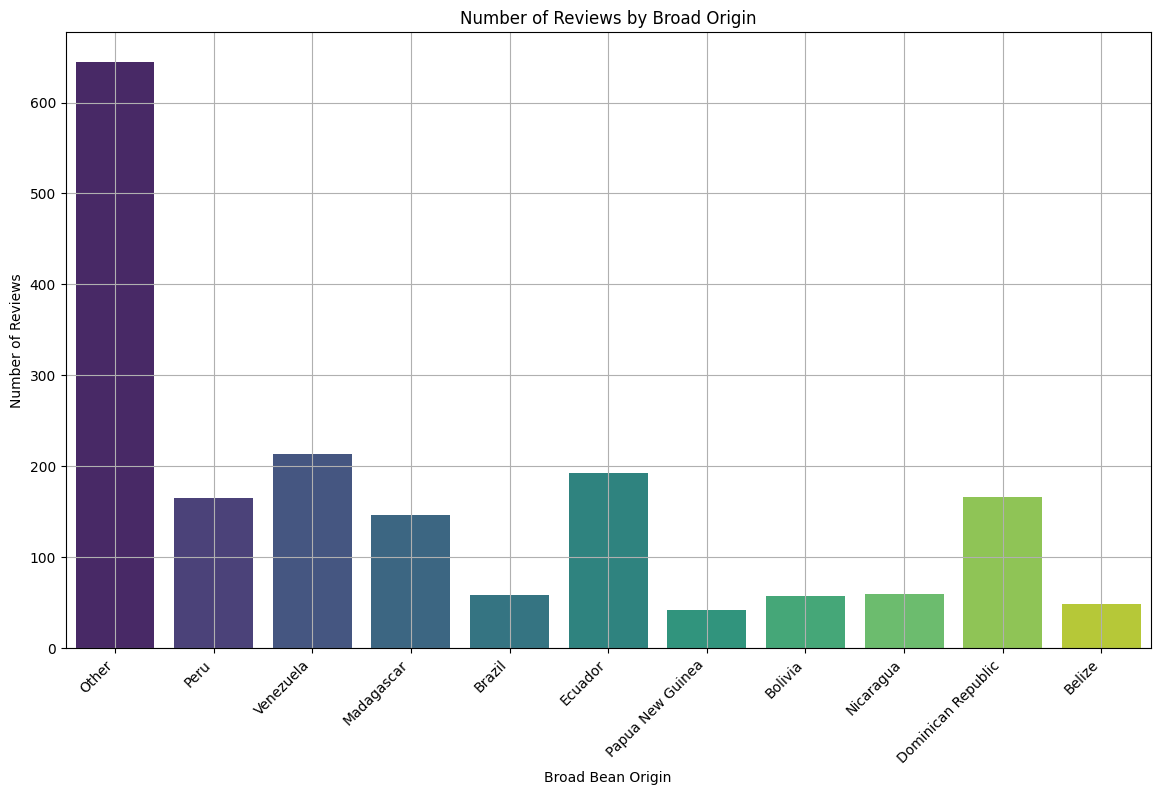

In [ ]:
# Broad Origin vs. Number of Reviews

# Set the figure size for the plot
plt.figure(figsize=(14, 8))

# Create a count plot of the number of reviews for each broad bean origin
sns.countplot(x='broad_origin', palette='viridis', data=df)

# Set the x-axis label
plt.xlabel('Broad Bean Origin')

# Set the y-axis label
plt.ylabel('Number of Reviews')

# Set the title of the plot
plt.title('Number of Reviews by Broad Origin')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add gridlines to the plot for better readability
plt.grid(True)

# Show the plot
plt.show()

Insights:

*   Venezuela has the most reviews
*   South American countries like Venezuela, Ecuador, and Peru are highly represented, indicating their importance in the chocolate

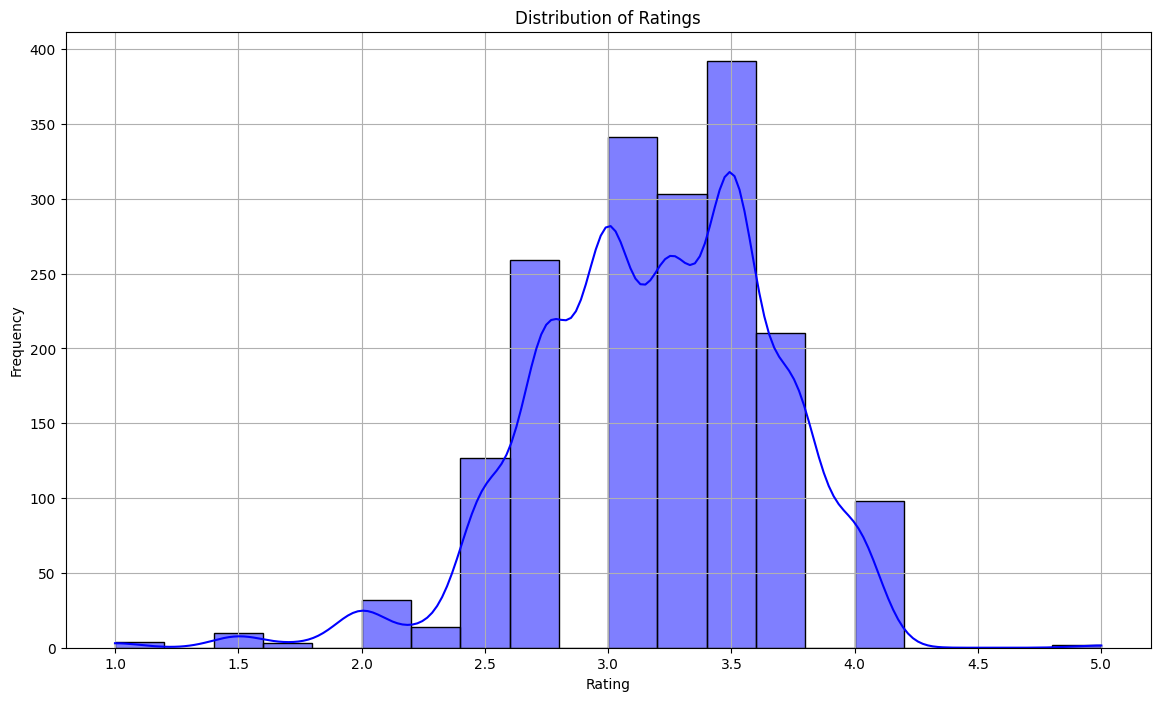

In [ ]:
# Rating Distribution

# Set the figure size for the plot
plt.figure(figsize=(14, 8))

# Create a histogram of the ratings with 20 bins and a kernel density estimate (KDE) line
sns.histplot(df['rating'], bins=20, kde=True, color='blue')

# Set the x-axis label
plt.xlabel('Rating')

# Set the y-axis label
plt.ylabel('Frequency')

# Set the title of the plot
plt.title('Distribution of Ratings')

# Add gridlines to the plot for better readability
plt.grid(True)

# Show the plot
plt.show()

Insights:

*   Most rating recieve a score of 3.5
*   Reviews are normaly distributed (bell shape)

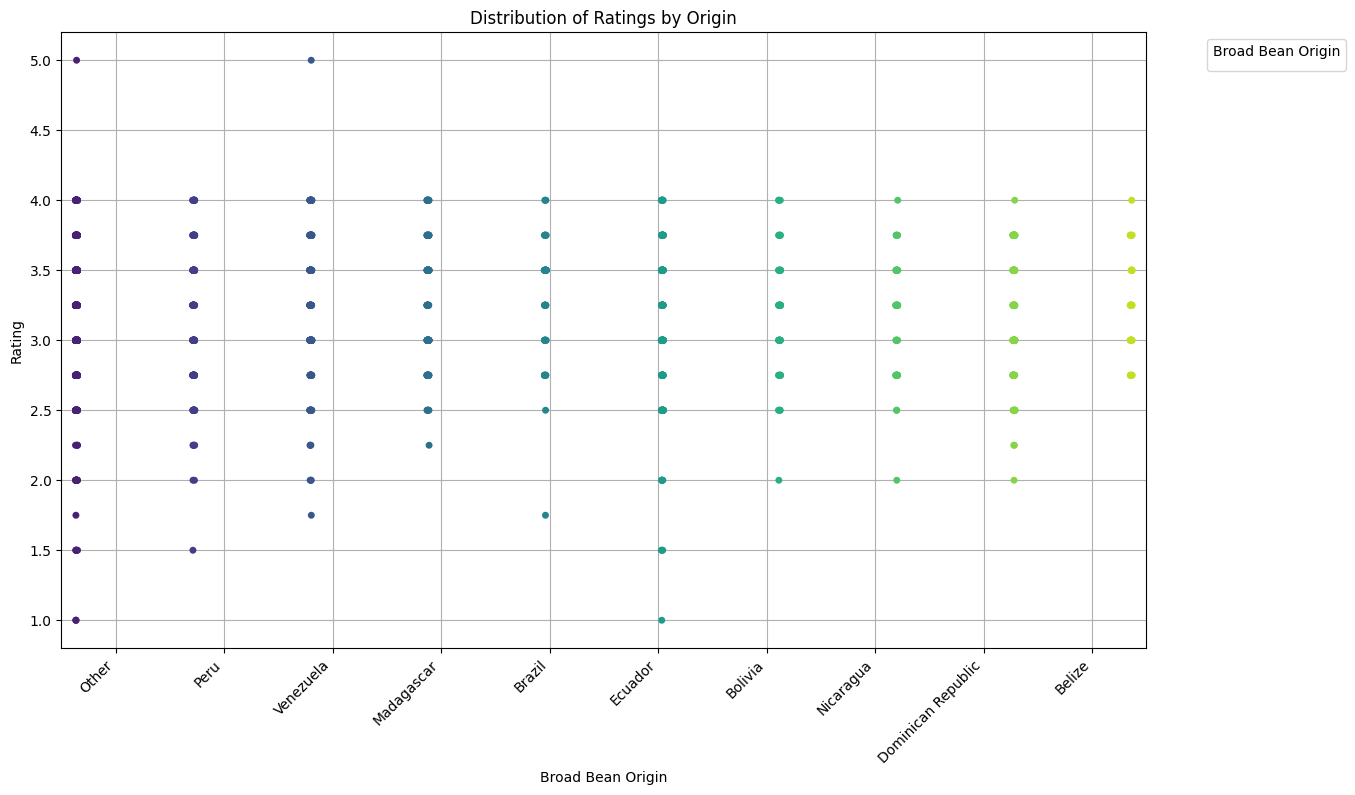

In [ ]:
# Combine less common origins into 'Other' category
top_origins = df['broad_origin'].value_counts().index[:10]
df['broad_origin'] = df['broad_origin'].apply(lambda x: x if x in top_origins else 'Other')

# Distribution of Ratings by Origin
plt.figure(figsize=(14, 8))  # Set the figure size for the plot

# Create a scatter plot of broad origin vs. rating, with points colored by broad origin
sns.stripplot(x='broad_origin', y='rating', hue='broad_origin', palette='viridis', data=df, jitter=True, dodge=True)

# Set the x-axis label
plt.xlabel('Broad Bean Origin')

# Set the y-axis label
plt.ylabel('Rating')

# Set the title of the plot
plt.title('Distribution of Ratings by Origin')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust the legend title and position it outside the plot
plt.legend(title='Broad Bean Origin', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add gridlines to the plot for better readability
plt.grid(True)

# Show the plot
plt.show()

Insights:

*   Venezuela is the only frequently reviewed country to recieve a 5 star
*   Belize has the fewest ratings but overall pretty high (smallest distribution range)

---
### Step 3: Data preprocessing

### <span style="color:chocolate">Exercise 4:</span> Prepare data for modeling (20 points)

Following the format of previous assignments, adhere to the following steps as a minimum:

1. Identify the features of interest;
2. Perform necessary cleaning on the features;
3. Reassess the outcome variable if desired (e.g., potentially reducing the number of classes, while ensuring a minimum of 3);
4. Shuffle the dataset;
5. Create training, validation, and test datasets using a 60/20/20 split;
6. Standardize the data;
7. Integrate any supplementary tasks deemed crucial for modeling, especially considering the chosen outcome variable.


	1.	Cocoa Percent (cocoa_percent):
	•	The percentage of cocoa in the chocolate can significantly impact the flavor profile and quality, which in turn affects the rating.

	2.	Broad Bean Origin (broad_origin):
	•	The origin of the cocoa beans can influence the taste and quality due to different growing conditions and bean varieties.

	3.	Company (company):
	•	Different companies have varying levels of expertise, production processes, and quality control, which can affect the ratings of their chocolate bars.

	5.	Bean Type (bean_type):
	•	The type of cocoa bean used (e.g., Criollo, Forastero, Trinitario) can affect the flavor and quality of the chocolate.

	7.	Company Location (company_location):
	•	The location of the company might capture regional preferences or production standards that influence the rating.

	8.	Ingredients (ingredients):
	•	The type and number of ingredients used in the chocolate (e.g., vanilla, lecithin) can affect its taste and quality.

	9.	Review Text (review_text) (if available):
	•	Sentiment analysis on the text of the review could provide additional insights into the factors affecting the rating.


In [ ]:
# Further cleaning and preprocessing for specific features of interest
def further_cleaning(df):
    '''Further cleaning and preprocessing of specific features for modeling.'''

    # Ensure 'cocoa_percent' is treated as a string, then convert to numeric and strip '%' symbol
    df['cocoa_percent'] = df['cocoa_percent'].astype(str).str.replace('%', '').astype(float)

    # Extract year from review_date for potential analysis
    df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
    df['review_year'] = df['review_date'].dt.year

    # Simplify bean type categories
    bean_type_mapping = {
        'Criollo': 'Criollo', 'Criollo (Porcelana)': 'Criollo', 'Criollo (Ocumare)': 'Criollo',
        'Criollo (Ocumare 61)': 'Criollo', 'Criollo (Ocumare 77)': 'Criollo', 'Criollo (Ocumare 67)': 'Criollo',
        'Criollo (Wild)': 'Criollo', 'Criollo (Amarru)': 'Criollo', 'Criollo, Trinitario': 'Criollo',
        'Forastero': 'Forastero', 'Forastero (Arriba)': 'Forastero', 'Forastero (Nacional)': 'Forastero',
        'Forastero (Catongo)': 'Forastero', 'Forastero (Parazinho)': 'Forastero', 'CCN51': 'Forastero',
        'Forastero (Arriba) ASS': 'Forastero', 'Forastero (Arriba) ASSS': 'Forastero', 'Forastero(Arriba, CCN)': 'Forastero',
        'Forastero (Amelonado)': 'Forastero', 'Trinitario': 'Trinitario', 'Trinitario (85% Criollo)': 'Trinitario',
        'Trinitario (Scavina)': 'Trinitario', 'Trinitario, Forastero': 'Trinitario', 'Forastero, Trinitario': 'Trinitario',
        'Trinitario, Nacional': 'Trinitario', 'Trinitario (Amelonado)': 'Trinitario', 'Trinitario, TCGA': 'Trinitario',
        'Blend': 'Blend', 'Blend-Forastero,Criollo': 'Blend', 'Amazon mix': 'Blend', 'Criollo, +': 'Blend',
        'Amazon': 'Blend', 'Amazon, ICS': 'Blend', 'EET': 'Blend', 'Matina': 'Blend', 'Nacional': 'Blend',
        'Beniano': 'Blend', 'Nacional (Arriba)': 'Blend'
    }

    df['simplified_bean_type'] = df['bean_type'].map(bean_type_mapping)

    # Convert categorical variables to numeric using one-hot encoding
    df = pd.get_dummies(df, columns=['broad_origin', 'maker', 'maker_location'], drop_first=True)

    # Drop columns that are not needed for modeling
    df = df.drop(columns=['specific_origin', 'reference_number', 'review_date', 'bean_type'])

    return df


df_cleaned = further_cleaning(df)

In [ ]:
df_cleaned.head()

,cocoa_percent,rating,review_year,simplified_bean_type,broad_origin_Bolivia,broad_origin_Brazil,broad_origin_Dominican Republic,broad_origin_Ecuador,broad_origin_Madagascar,broad_origin_Nicaragua,...,maker_location_South Korea,maker_location_Spain,maker_location_St. Lucia,maker_location_Suriname,maker_location_Sweden,maker_location_Switzerland,maker_location_U.S.A.,maker_location_Venezuela,maker_location_Vietnam,maker_location_Wales
0,63.00,3.75,1970,Blend,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,70.00,2.75,1970,Blend,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,70.00,3.00,1970,Blend,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,70.00,3.50,1970,Blend,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,70.00,3.50,1970,Blend,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Shuffle the entire dataframe
df_cleaned = df_cleaned.sample(frac=1, random_state=1234).reset_index(drop=True)

# Prepare features (x) and labels (y)
x = df_cleaned.drop(columns=['simplified_bean_type'])  # Drop the target column from the features
y = df_cleaned['simplified_bean_type']  # Target variable

# Split the data into training and testing sets (60% train, 20% val, 20% test)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(x, y, test_size=0.2, random_state=1234)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=1234)

# Print the shapes of the training and testing sets
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (1077, 482), Y_train shape: (1077,)
X_val shape: (359, 482), Y_val shape: (359,)
X_test shape: (359, 482), Y_test shape: (359,)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_std = scaler.fit_transform(X_train)

# Transform the validation and test data using the same scaler
X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)

# Print the shapes to verify
print(f"X_train_std shape: {X_train_std.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val_std shape: {X_val_std.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test_std shape: {X_test_std.shape}, Y_test shape: {Y_test.shape}")

X_train_std shape: (1077, 482), Y_train shape: (1077,)
X_val_std shape: (359, 482), Y_val shape: (359,)
X_test_std shape: (359, 482), Y_test shape: (359,)


In [ ]:
# Ensure that all missing values have been appropriately handled

# Identify missing values
missing_values_sum = df_cleaned.isnull().sum()
print(f"Missing values sum: {missing_values_sum}\n")

# Analyze missing values
missing_data = df_cleaned[missing_values_sum[missing_values_sum > 0].index]
print(f"Missing data:\n{missing_data}\n")

Missing values sum: cocoa_percent                 0
rating                        0
review_year                   0
simplified_bean_type          2
broad_origin_Bolivia          0
                             ..
maker_location_Switzerland    0
maker_location_U.S.A.         0
maker_location_Venezuela      0
maker_location_Vietnam        0
maker_location_Wales          0
Length: 483, dtype: int64

Missing data:
     simplified_bean_type
0                   Blend
1                   Blend
2                   Blend
3                   Blend
4                   Blend
...                   ...
1790                Blend
1791           Trinitario
1792           Trinitario
1793                Blend
1794            Forastero

[1795 rows x 1 columns]



---
### Step 4: Exploratory data analysis (EDA) - cont'd

### <span style="color:chocolate">Exercise 5:</span> More plots (5 points)

Conduct any further exploratory data analysis (EDA) you believe necessary to validate the successful preprocessing of the data.

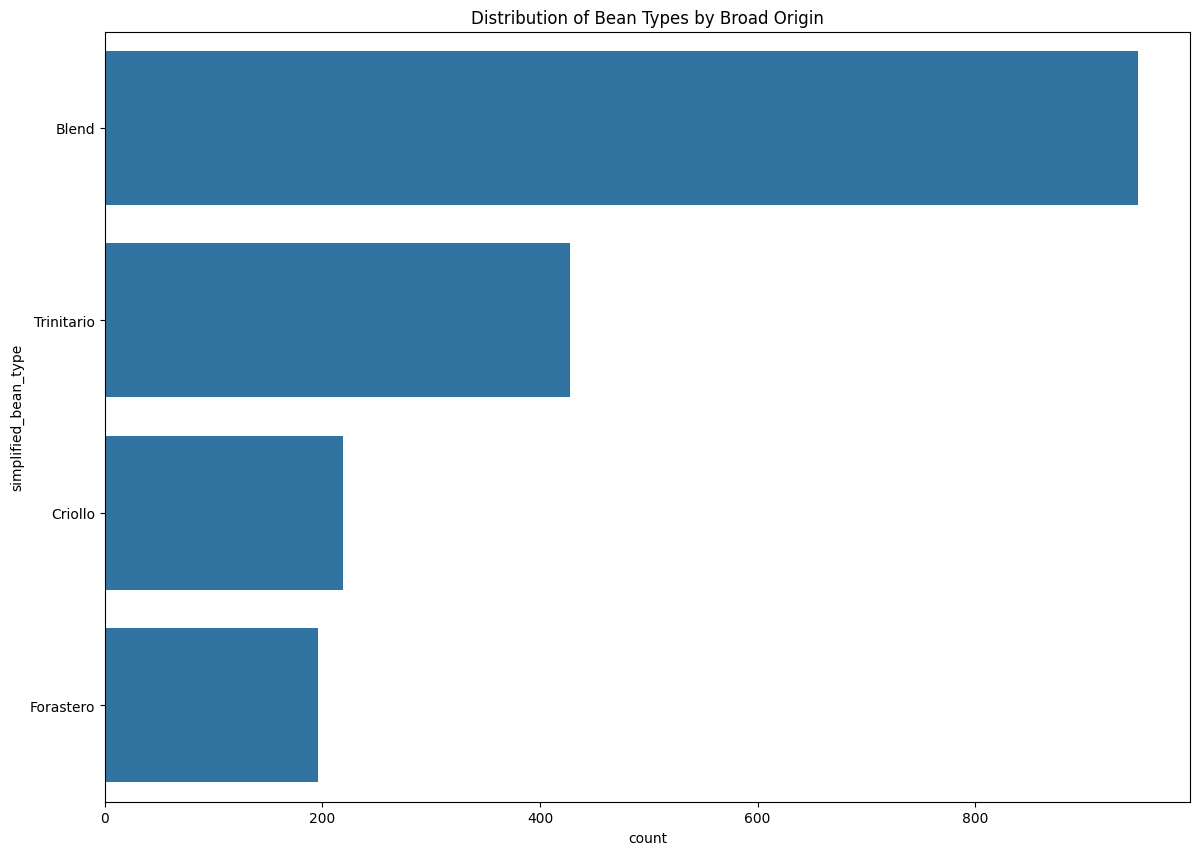

In [ ]:
# Plot the distribution of 'simplified_bean_type' for each 'broad_origin'
plt.figure(figsize=(14, 10))
sns.countplot(y='simplified_bean_type', data=df_cleaned)
plt.title("Distribution of Bean Types by Broad Origin")
plt.show()

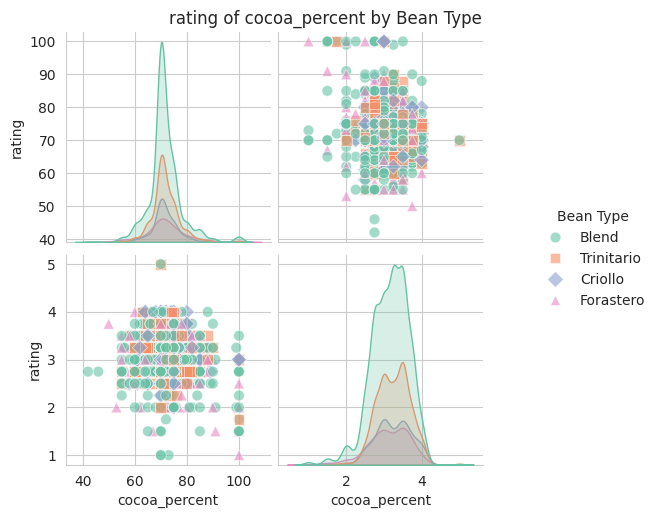

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Select a subset of numerical features and add the target variable for pair plotting
pair_plot_df = df_cleaned[['cocoa_percent', 'rating', 'simplified_bean_type']]

# Create the pair plot with enhanced aesthetics
pair_plot = sns.pairplot(
    pair_plot_df,
    hue='simplified_bean_type',
    diag_kind='kde',
    palette='Set2',
    markers=["o", "s", "D", "^"],
    plot_kws={'alpha':0.6, 's':60, 'edgecolor':'w'},
    height=2.5
)

# Adjust titles and labels
pair_plot.fig.suptitle("rating of cocoa_percent by Bean Type", y=1.02)
pair_plot.set(xlabel='cocoa_percent', ylabel='rating')

# Adjust legend
pair_plot._legend.set_title('Bean Type')
plt.show()


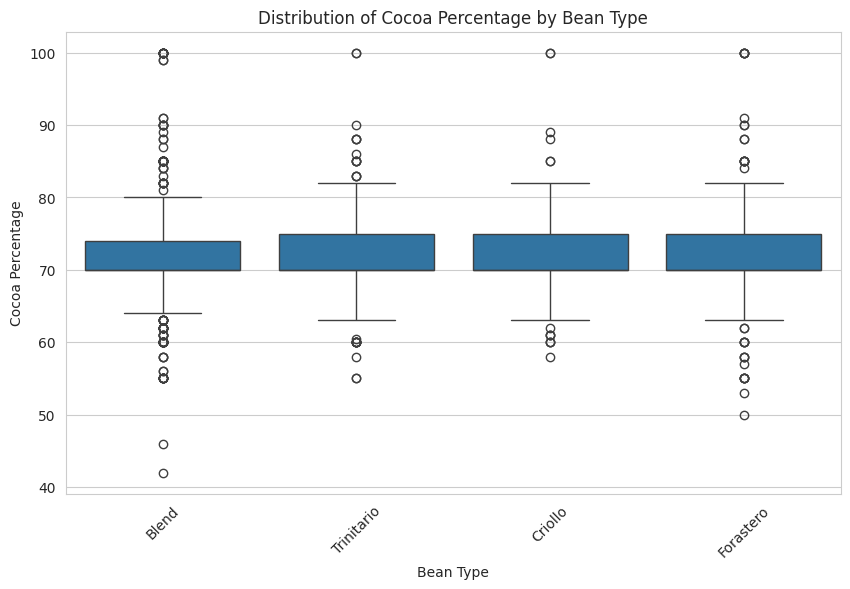

<ipython-input-238-d0b59b4639a1>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_cleaned, x='simplified_bean_type', y='rating', estimator=np.mean, ci='sd')


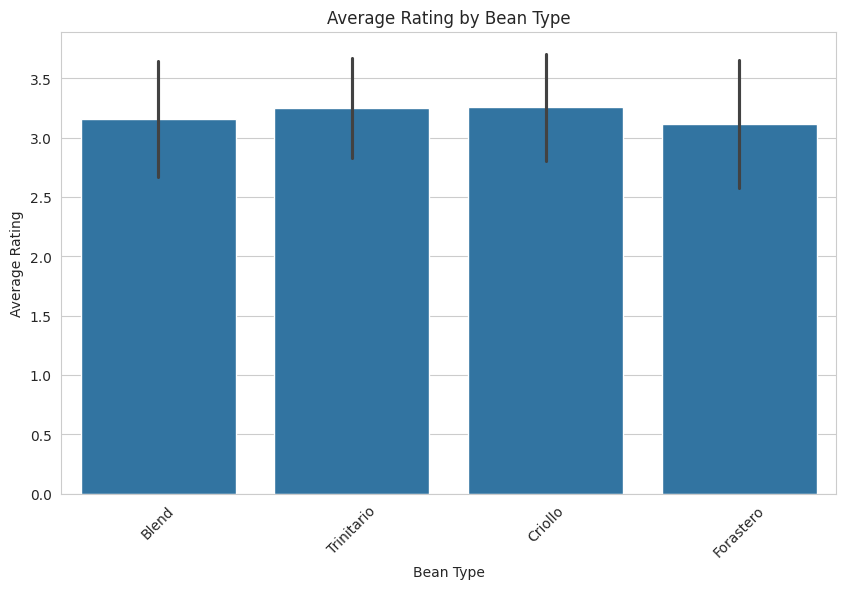

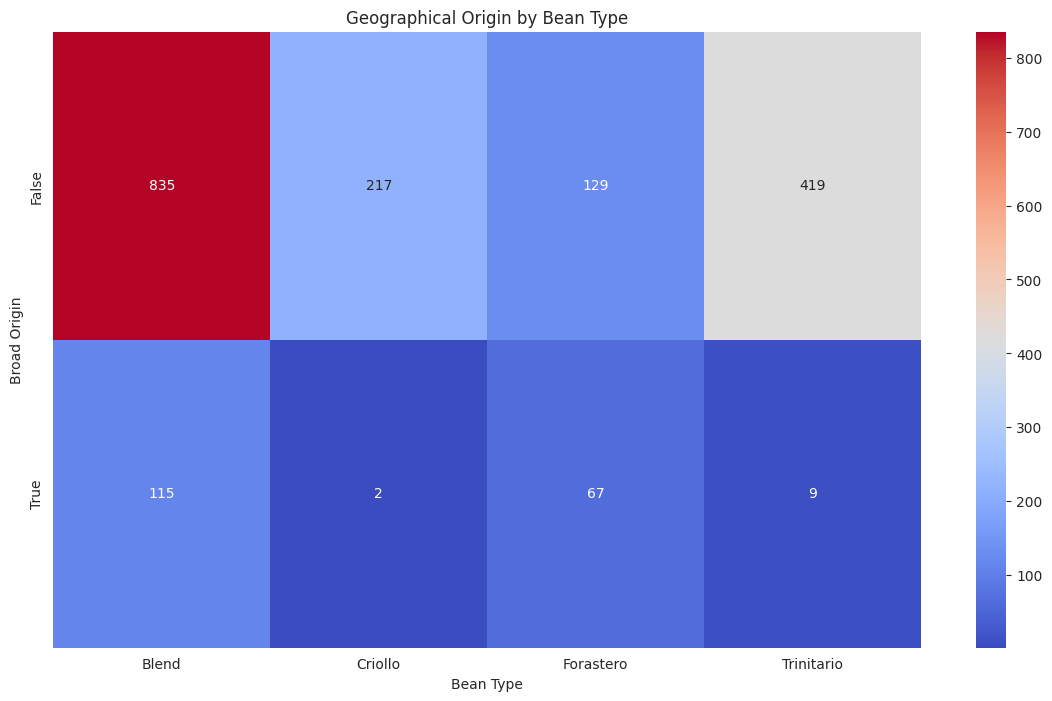

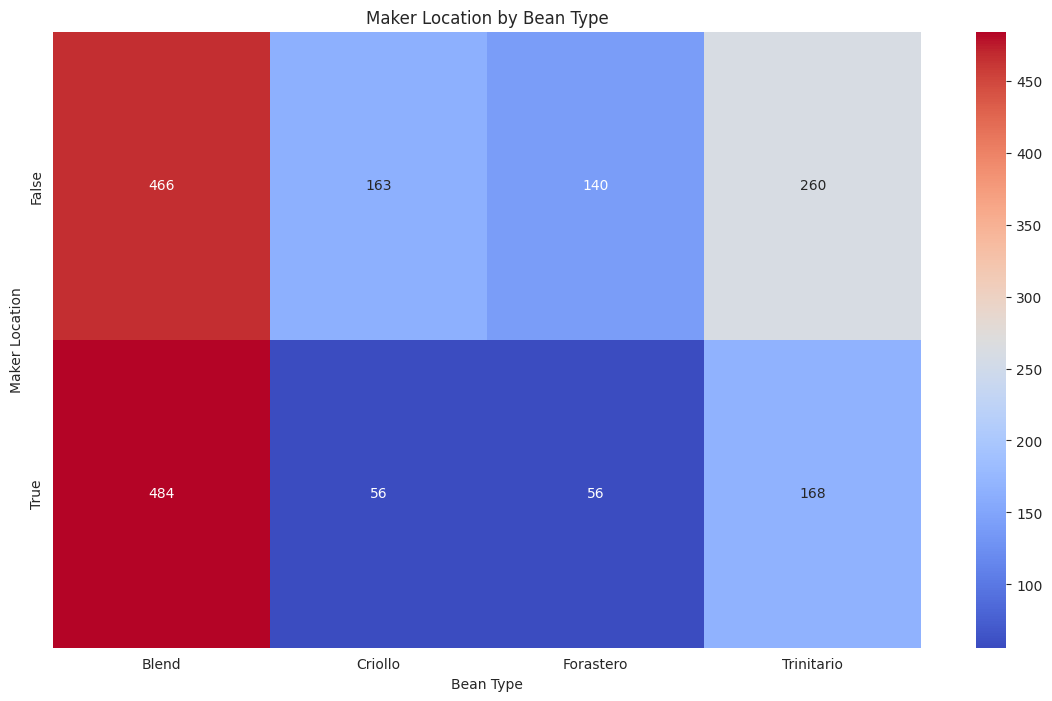

In [ ]:
# Plot 1: Distribution of Cocoa Percentage by Bean Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned, x='simplified_bean_type', y='cocoa_percent')
plt.title('Distribution of Cocoa Percentage by Bean Type')
plt.xlabel('Bean Type')
plt.ylabel('Cocoa Percentage')
plt.xticks(rotation=45)
plt.show()

# Plot 2: Average Rating by Bean Type
plt.figure(figsize=(10, 6))
sns.barplot(data=df_cleaned, x='simplified_bean_type', y='rating', estimator=np.mean, ci='sd')
plt.title('Average Rating by Bean Type')
plt.xlabel('Bean Type')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

# Plot 3: Geographical Origin by Bean Type
plt.figure(figsize=(14, 8))
origin_bean_heatmap = pd.crosstab(df_cleaned['broad_origin_Ecuador'], df_cleaned['simplified_bean_type'])
sns.heatmap(origin_bean_heatmap, annot=True, cmap='coolwarm', fmt='d')
plt.title('Geographical Origin by Bean Type')
plt.xlabel('Bean Type')
plt.ylabel('Broad Origin')
plt.show()

# Plot 4: Maker Location by Bean Type
plt.figure(figsize=(14, 8))
maker_bean_heatmap = pd.crosstab(df_cleaned['maker_location_U.S.A.'], df_cleaned['simplified_bean_type'])
sns.heatmap(maker_bean_heatmap, annot=True, cmap='coolwarm', fmt='d')
plt.title('Maker Location by Bean Type')
plt.xlabel('Bean Type')
plt.ylabel('Maker Location')
plt.show()


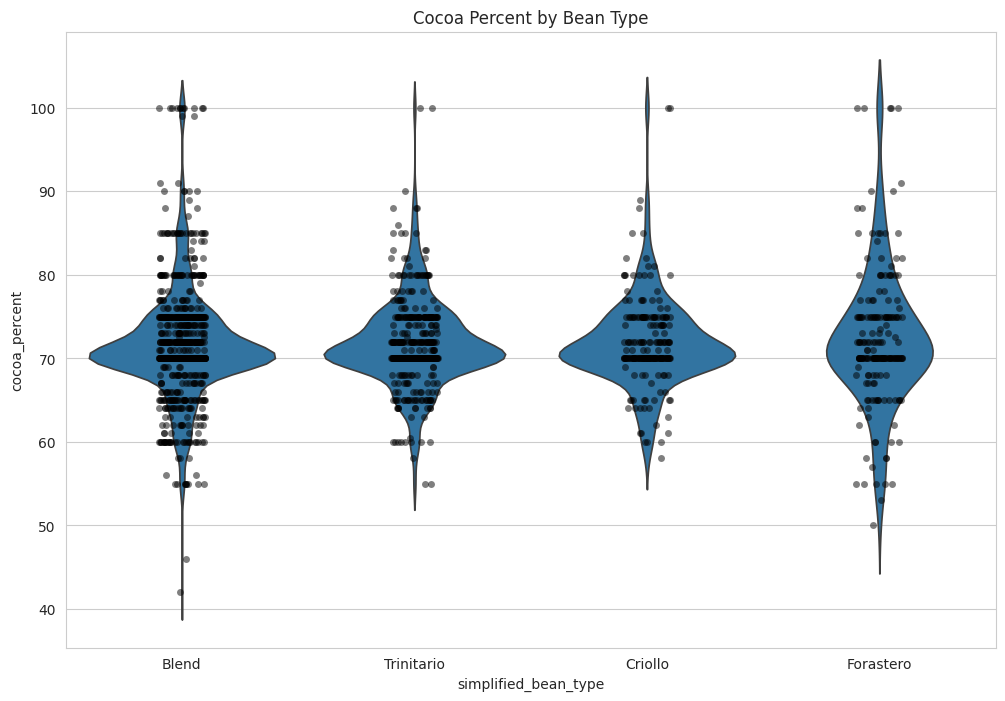

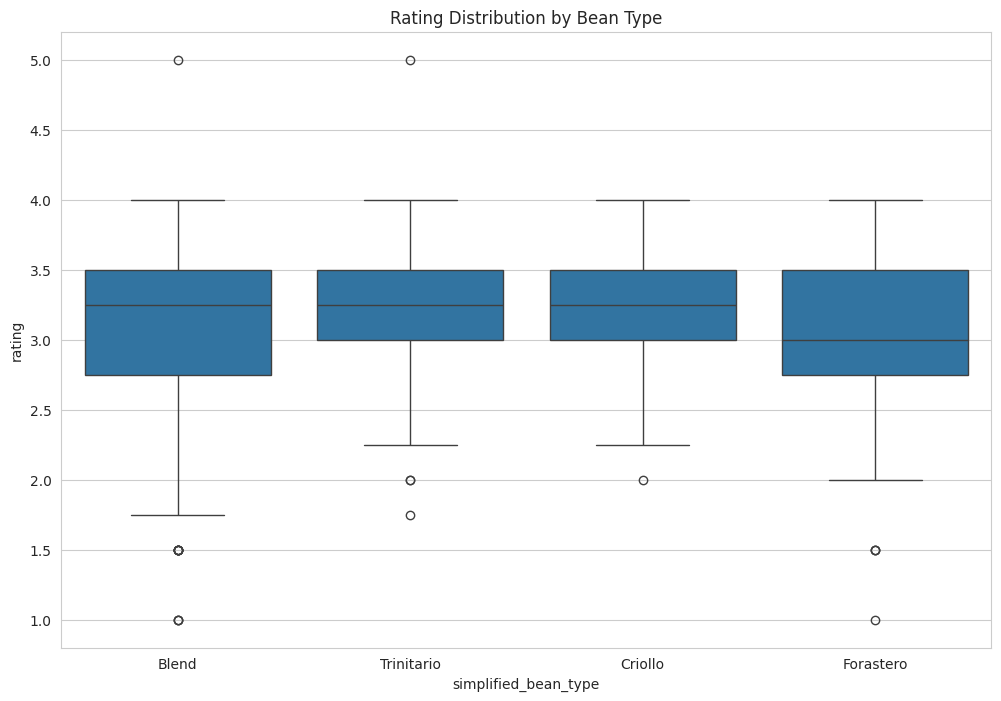

In [ ]:
# Plotting Cocoa Percent by Bean Type
plt.figure(figsize=(12, 8))
sns.violinplot(x='simplified_bean_type', y='cocoa_percent', data=df_cleaned, inner=None)
sns.stripplot(x='simplified_bean_type', y='cocoa_percent', data=df_cleaned, color='k', alpha=0.5)
plt.title("Cocoa Percent by Bean Type")
plt.show()

# Plotting Rating Distribution by Bean Type
plt.figure(figsize=(12, 8))
sns.boxplot(x='simplified_bean_type', y='rating', data=df_cleaned)
plt.title("Rating Distribution by Bean Type")
plt.show()


FINDINGS
------------------------------
Geographical Origin by Bean Type:

This plot shows the distribution of different bean types based on their geographical origin. Certain bean types are more common in specific regions.

Maker Location by Bean Type:

This plot illustrates the distribution of bean types based on the location of the chocolate maker. Tells us if specific bean types are preferred by makers in certain regions.

Cocoa Percent by Bean Type:

This violin plot shows the distribution of cocoa percentage for different bean types. It helps to visualize the spread and density of cocoa percentages within each bean type.

Rating Distribution by Bean Type:

This box plot shows the distribution of ratings for each bean type. It can help determine if certain bean types generally receive higher or lower ratings compared to others.




---
### Step 5: Modeling

### <span style="color:chocolate">Exercise 6:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

1. Implement this baseline and report the accuracy metric on the train data;

2. Implement a function that computes the Log Loss (cross-entropy loss) metric and use it to evaluate this baseline on both the train and validation data. Note: reflect on what you know about the original distribution of classes in your training data (Hint: see Assignment 4 - Exercise 8 and ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example).

In [ ]:
# Remove NaN labels from Y_train and Y_val
Y_train = Y_train.dropna()
Y_val = Y_val.dropna()

# Convert the labels to string type to avoid comparison issues
Y_train = Y_train.astype(str)
Y_val = Y_val.astype(str)

# Step 1: Identify the most common label in the training set
most_common_label = Y_train.mode()[0]  # Here, we determine the most frequently occurring label in the training set.
print(f"The most common label in the training set is: {most_common_label}")

# Step 2: Predict the most common label for all inputs in the training set
most_common_predictions = [most_common_label] * len(Y_train)  # We create a list where every entry is the most common label. This represents our baseline model's prediction for every instance in the training set.
print(f"The predicted label for all inputs in the training set is: {most_common_predictions[:10]}...")  # Print only the first 10 predictions for brevity

num_classes = Y_train.nunique()  # We determine how many unique classes (labels) exist.
print(f"The number of classes in the training set is: {num_classes}")

unique_classes = Y_train.unique()  # Get unique classes
class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}  # We map each class to an index, which is necessary for one-hot encoding and for easily handling the labels numerically.
print(f"Class to index mapping: {class_to_index}")

# Ensure the length of most_common_predictions matches Y_train length
most_common_predictions = most_common_predictions[:len(Y_train)]

# Step 3: Calculate the accuracy of the baseline model on the training data
accuracy = accuracy_score(Y_train, most_common_predictions)  # We compare the baseline predictions with the actual labels to calculate accuracy.
print(f"The accuracy of the baseline model on the training data is: {accuracy}")


The most common label in the training set is: Blend
The predicted label for all inputs in the training set is: ['Blend', 'Blend', 'Blend', 'Blend', 'Blend', 'Blend', 'Blend', 'Blend', 'Blend', 'Blend']...
The number of classes in the training set is: 5
Class to index mapping: {'Blend': 0, 'Criollo': 1, 'Trinitario': 2, 'Forastero': 3, 'nan': 4}
The accuracy of the baseline model on the training data is: 0.5116063138347261


Purpose and Goal:
The goal of this approach is to establish a baseline model's performance. This baseline model predicts the most common class. By calculating its accuracy, we get a reference point for evaluating more sophisticated models.

In [ ]:
# Log Loss function implementation

def log_loss(labels, predicted_probabilities):
    """Compute the Log Loss (Cross-Entropy Loss).

    Args:
        labels: Actual labels (one-hot encoded or binary).
        predicted_probabilities: Predicted probabilities for each class.

    Returns:
        float: The average log loss value.
    """

    # Clip predictions to prevent log(0)
    predicted_probabilities = np.clip(predicted_probabilities, 1e-15, 1 - 1e-15)

    # Compute the cross-entropy loss for each sample
    log_loss = -np.sum(labels * np.log(predicted_probabilities), axis=1)

    # Compute the average log loss
    norm_log = np.mean(log_loss)

    # Return the loss value
    return norm_log


GOAL: By minimizing the cross-entropy loss during training, we ensure that our model's predicted probabilities are as close as possible to the actual labels, resulting in better classification performance.

In [ ]:
# Convert labels to one-hot encoding
def to_one_hot(labels, num_classes):
    """Convert labels to one-hot encoded format.

    Args:
        labels: List of label indices.
        num_classes: Total number of classes.

    Returns:
        np.ndarray: One-hot encoded array.
    """
    # Creates a matrix filled with zeros of shape (number_of_samples, number_of_classes).
    one_hot = np.zeros((len(labels), num_classes))

    for i, label in enumerate(labels):
        # For each label, set the corresponding position in the matrix to 1.
        one_hot[i, label] = 1

    # The result is a one-hot encoded representation of the input labels, which is useful for training and evaluating classification models.
    return one_hot

In [ ]:

# Convert the labels in Y_train to indices
Y_train_indices = [class_to_index[label] for label in Y_train]
Y_val_indices = [class_to_index[label] for label in Y_val]

# Convert the indices to one-hot encoding
Y_train_one_hot = to_one_hot(Y_train_indices, num_classes)
Y_val_one_hot = to_one_hot(Y_val_indices, num_classes)

# Create predicted probabilities for the baseline model
baseline_train_predictions = np.zeros((len(Y_train), num_classes))
baseline_train_predictions[:, class_to_index[most_common_label]] = 1

baseline_val_predictions = np.zeros((len(Y_val), num_classes))
baseline_val_predictions[:, class_to_index[most_common_label]] = 1

# Compute log loss for both training and validation sets
train_log_loss = log_loss(Y_train_one_hot, baseline_train_predictions)
val_log_loss = log_loss(Y_val_one_hot, baseline_val_predictions)

print(f"Baseline Log Loss on Training Data: {train_log_loss:.4f}")
print(f"Baseline Log Loss on Validation Data: {val_log_loss:.4f}")

Baseline Log Loss on Training Data: 16.8685
Baseline Log Loss on Validation Data: 15.0504


Recap of Results:
-----------------
Baseline Model Accuracy: 51%

Baseline Log Loss on Training Data: 16.8685

Baseline Log Loss on Validation Data: 15.0504

These results provide a baseline to compare more sophisticated models against. The high log loss values indicate that our baseline model, which predicts the most common label for every instance, performs poorly. The goal is to develop more advanced models that significantly reduce the log loss and improve accuracy.

### <span style="color:chocolate">Exercise 7:</span> Improvement over baseline with Tensorflow (10 points)

Use TensorFlow (TF) to train a multiclass logistic regression model much like you did in Assignment 4. The goal here is to build a ML model to improve over the baseline classifier. You have the flexibility to choose which features to include.

With this in mind, complete the following tasks:

1. Build and compile a multiclass classification TF model (call it model_tf). Hint: the activation function, the loss, and the evaluation metric are different compared to the binary logistic regression (see ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example). Set learning_rate = 0.0001.
2. Train model_tf using the training dataset and pass the validation data for validation. Set num_epochs = 10 and batch_size = 32.
3. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title.

If instructions for any other hyperparameters are not provided here, you are free to select your own or use the default settings.

In [ ]:
# Verify lengths of data
print(f"Length of X_train_std: {len(X_train_std)}")
print(f"Length of Y_train: {len(Y_train)}")
print(f"Length of X_val_std: {len(X_val_std)}")
print(f"Length of Y_val: {len(Y_val)}")

# Ensure X_train_std and Y_train have the same number of samples
if len(X_train_std) != len(Y_train):
    min_length = min(len(X_train_std), len(Y_train))
    X_train_std = X_train_std[:min_length]
    Y_train = Y_train[:min_length]

# Ensure X_val_std and Y_val have the same number of samples
if len(X_val_std) != len(Y_val):
    min_length = min(len(X_val_std), len(Y_val))
    X_val_std = X_val_std[:min_length]
    Y_val = Y_val[:min_length]

# Remove NaN labels from Y_train and Y_val
Y_train = Y_train.dropna()
Y_val = Y_val.dropna()

# Convert the labels to string type to avoid comparison issues
Y_train = Y_train.astype(str)
Y_val = Y_val.astype(str)

# Encode the labels
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.fit_transform(Y_val)

Y_train_encoded = Y_train_encoded.astype('int')
Y_val_encoded = Y_val_encoded.astype('int')

X_train_std = X_train_std.astype('float32')
X_val_std = X_val_std.astype('float32')

# Verify lengths after processing
print(f"Length of X_train_std: {len(X_train_std)}")
print(f"Length of Y_train_encoded: {len(Y_train_encoded)}")
print(f"Length of X_val_std: {len(X_val_std)}")
print(f"Length of Y_val_encoded: {len(Y_val_encoded)}")

Length of X_train_std: 1077
Length of Y_train: 1077
Length of X_val_std: 359
Length of Y_val: 358
Length of X_train_std: 1077
Length of Y_train_encoded: 1077
Length of X_val_std: 358
Length of Y_val_encoded: 358


In [ ]:
# Number of features and classes
num_features = X_train_std.shape[1]
num_classes = len(np.unique(Y_train_encoded))
print(f"Number of features: {num_features}")
print(f"Number of classes: {num_classes}")

# Create a Sequential model
model_tf = Sequential()

# Add a dense layer with softmax activation for multi-class classification
model_tf.add(Dense(num_classes, activation='softmax', input_shape=(num_features,)))


Number of features: 482
Number of classes: 5


Epoch 1/10
34/34 [==============================] - 1s 9ms/step - loss: 2.0582 - accuracy: 0.2163 - val_loss: 2.0005 - val_accuracy: 0.2235
Epoch 2/10
34/34 [==============================] - 0s 3ms/step - loss: 2.0268 - accuracy: 0.2321 - val_loss: 1.9824 - val_accuracy: 0.2318
Epoch 3/10
34/34 [==============================] - 0s 3ms/step - loss: 1.9980 - accuracy: 0.2386 - val_loss: 1.9650 - val_accuracy: 0.2374
Epoch 4/10
34/34 [==============================] - 0s 3ms/step - loss: 1.9698 - accuracy: 0.2498 - val_loss: 1.9485 - val_accuracy: 0.2486
Epoch 5/10
34/34 [==============================] - 0s 4ms/step - loss: 1.9423 - accuracy: 0.2656 - val_loss: 1.9319 - val_accuracy: 0.2514
Epoch 6/10
34/34 [==============================] - 0s 3ms/step - loss: 1.9152 - accuracy: 0.2748 - val_loss: 1.9165 - val_accuracy: 0.2542
Epoch 7/10
34/34 [==============================] - 0s 4ms/step - loss: 1.8886 - accuracy: 0.2851 - val_loss: 1.9004 - val_accuracy: 0.2598
Epoch 8/10
34/34 [==

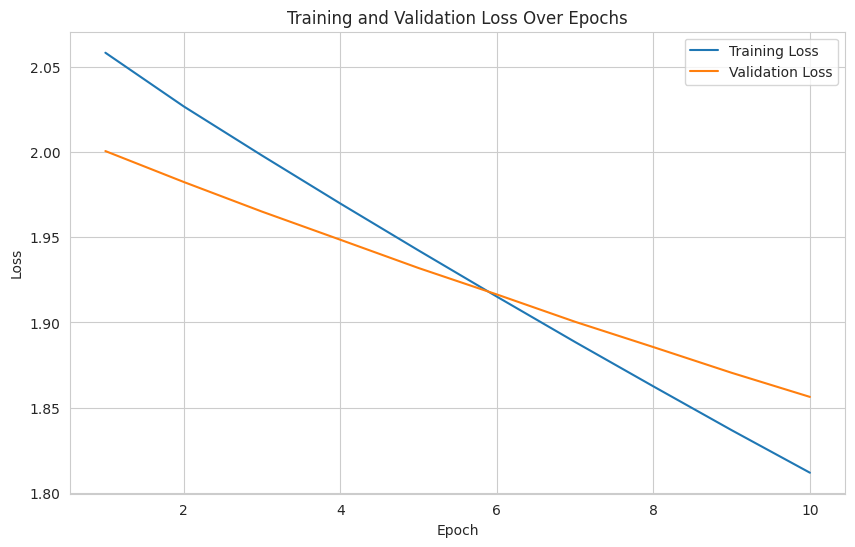

The training loss is: 1.811893105506897
The validation loss is: 1.8563566207885742


In [ ]:
# Set learning rate
learning_rate = 0.0001

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model_tf.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
num_epochs = 10
batch_size = 32

history = model_tf.fit(X_train_std, Y_train_encoded, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val_std, Y_val_encoded))

# Evaluate the model on validation data
val_loss, val_accuracy = model_tf.evaluate(X_val_std, Y_val_encoded)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Extract the loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

print(f"The training loss is: {train_loss[-1]}")
print(f"The validation loss is: {val_loss[-1]}")

---
### Step 6: Hyperparameter tuning

### <span style="color:chocolate">Exercise 8:</span> Choosing hyperparameters (10 points)

1. Fine-tune the hyperparameters of *model_tf* to determine the setup that yields the most optimal performance. Feel free to explore various values for the hyperparameters. Hint: ask your instructors and TAs for help if in doubt.

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

Best Validation Loss: 1.2121951580047607
Best Hyperparameters: {'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 50, 'dropout_rate': 0.5, 'l2_regularization': 0.001, 'optimizer': <keras.src.optimizers.legacy.adam.Adam object at 0x7d0c006f80a0>}
Epoch 1/50
17/17 [==============================] - 1s 20ms/step - loss: 2.3662 - accuracy: 0.2581 - val_loss: 1.8176 - val_accuracy: 0.3994
Epoch 2/50
17/17 [==============================] - 0s 7ms/step - loss: 2.0067 - accuracy: 0.3649 - val_loss: 1.5938 - val_accuracy: 0.4888
Epoch 3/50
17/17 [==============================] - 0s 6ms/step - loss: 1.7800 - accuracy: 0.4178 - val_loss: 1.4943 - val_accuracy: 0.5279
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 1.6619 - accuracy: 0.4420 - val_loss: 1.4333 - val_accuracy: 0.5447
Epoch 5/50
17/17 [==============================] - 0s 6ms/step - loss: 1.5361 - accuracy: 0.4949 - val_loss: 1.3913 - val_accuracy: 0.5615
Epoch 6/50
17/17 [==============================] 

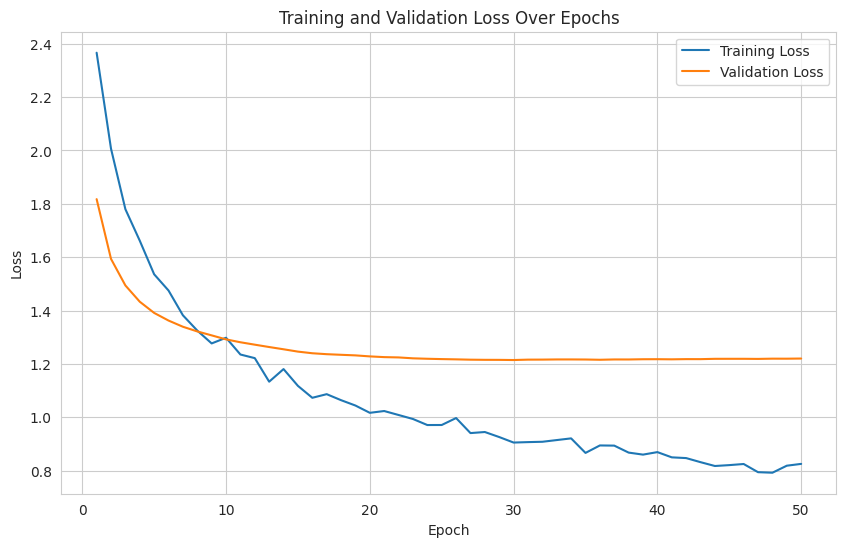

Final Training Loss: 0.8256
Final Validation Loss: 1.2204
Percentage Difference between Training and Validation Loss: 47.81%


In [ ]:
# Hyperparameters to explore
hyperparameters = [
    {
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 20,
        'dropout_rate': 0.2,
        'l2_regularization': 0.01,
        'optimizer': Adam(learning_rate=0.001)
    },
    {
        'learning_rate': 0.0001,
        'batch_size': 64,
        'epochs': 50,
        'dropout_rate': 0.5,
        'l2_regularization': 0.001,
        'optimizer': Adam(learning_rate=0.0001)
    },
    {
        'learning_rate': 0.01,
        'batch_size': 128,
        'epochs': 30,
        'dropout_rate': 0.3,
        'l2_regularization': 0.01,
        'optimizer': SGD(learning_rate=0.01)
    }
]

# Variables to track the best hyperparameters
best_val_loss = float('inf')
best_hyperparams = None

# Perform hyperparameter tuning
for params in hyperparameters:
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(num_features,),
                    kernel_regularizer=l2(params['l2_regularization'])))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=params['optimizer'],
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(X_train_std, Y_train_encoded,
                        epochs=params['epochs'],
                        batch_size=params['batch_size'],
                        validation_data=(X_val_std, Y_val_encoded),
                        verbose=0)

    val_loss = min(history.history['val_loss'])

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparams = params

print(f"Best Validation Loss: {best_val_loss}")
print(f"Best Hyperparameters: {best_hyperparams}")

# Build the final model using the best hyperparameters
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(num_features,),
                kernel_regularizer=l2(best_hyperparams['l2_regularization'])))
model.add(Dropout(best_hyperparams['dropout_rate']))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer=best_hyperparams['optimizer'],
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the final model
history = model.fit(X_train_std, Y_train_encoded,
                    epochs=best_hyperparams['epochs'],
                    batch_size=best_hyperparams['batch_size'],
                    validation_data=(X_val_std, Y_val_encoded))

# Evaluate the final model on validation data
val_loss, val_accuracy = model.evaluate(X_val_std, Y_val_encoded)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Extract the first five learned parameters including the bias term
weights, biases = model.layers[0].get_weights()
print(f"First five weights: {weights[:5]}")
print(f"Biases: {biases[:5]}")

# Extract the loss history
train_loss = history.history['loss']
val_loss_history = history.history['val_loss']

# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Calculate percentage difference between training and validation loss
final_train_loss = train_loss[-1]
final_val_loss = val_loss_history[-1]
percentage_diff = ((final_val_loss - final_train_loss) / final_train_loss) * 100

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Percentage Difference between Training and Validation Loss: {percentage_diff:.2f}%")

---
### Step 7: Evaluation and generalization

[link text](https://)### <span style="color:chocolate">Exercise 9:</span> Compute metrics (5 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate aggregate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras. and the <span style="color:chocolate">np.max()</span> method available in NumPy.

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [ ]:
# Predict probabilities on the train and test datasets
train_probabilities = model.predict(X_train_std)
test_probabilities = model.predict(X_test_std)

# Convert probabilities to class labels using argmax
train_predictions = np.argmax(train_probabilities, axis=1)
test_predictions = np.argmax(test_probabilities, axis=1)

# Calculate accuracy on the train and test datasets
train_accuracy = accuracy_score(Y_train_encoded, train_predictions)
test_accuracy = accuracy_score(Y_test_encoded, test_predictions)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Interpretation
if train_accuracy > test_accuracy:
    print("The model performs better on the training data than on the test data, indicating potential overfitting.")
elif train_accuracy < test_accuracy:
    print("The model performs better on the test data than on the training data, indicating potential underfitting.")
else:
    print("The model performs equally well on both training and test data, indicating good generalization capabilities.")


12/12 [==============================] - 0s 3ms/step
Train Accuracy: 0.7855
Test Accuracy: 0.3092
The model performs better on the training data than on the test data, indicating potential overfitting.


### <span style="color:chocolate">Exercise 10:</span> Additional metrics (10 points)

Using the test dataset:

1. Plot the confusion matrix. Identify which class the model confuses the most.

2. Determine which class has the lowest precision. What is the precision? Which class is the largest source of false positives?

3. Determine which class has the lowest recall. What is the recall? Which class is the largest source of false negatives?

11/11 [==============================] - 0s 2ms/step


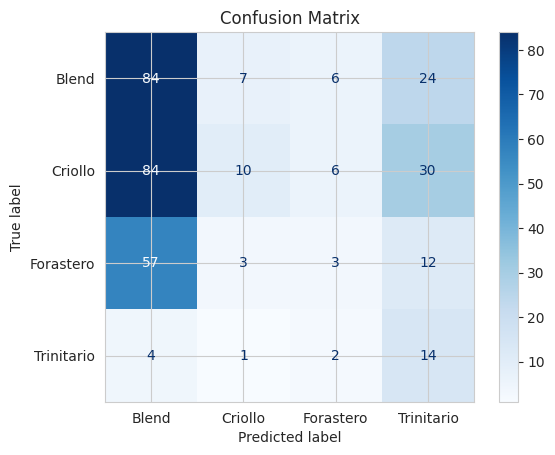

Lowest Precision Class: Trinitario
Precision: 0.175


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

# Filter out any invalid labels from the test set
valid_indices = Y_test_encoded != 4
X_test_std_filtered = X_test_std[valid_indices]
Y_test_encoded_filtered = Y_test_encoded[valid_indices]

# Predict probabilities on the filtered test dataset
test_probabilities = model.predict(X_test_std_filtered)

# Convert probabilities to class labels using argmax
test_predictions = np.argmax(test_probabilities, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(Y_test_encoded_filtered, test_predictions)

# Get the unique classes from the filtered test predictions and the label encoder
unique_classes_test = label_encoder.inverse_transform(np.unique(Y_test_encoded_filtered))

# Plot the confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes_test)
cmd.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision for each class
precision = precision_score(Y_test_encoded_filtered, test_predictions, average=None)
lowest_precision_class = unique_classes_test[np.argmin(precision)]
print(f"Lowest Precision Class: {lowest_precision_class}")
print(f"Precision: {precision[np.argmin(precision)]}")

# Calculate recall for each


In [ ]:
from sklearn.metrics import precision_score, recall_score

# Calculate precision for each class
precision = precision_score(Y_test_encoded_filtered, test_predictions, average=None)
lowest_precision_class = unique_classes_test[np.argmin(precision)]
print(f"Lowest Precision Class: {lowest_precision_class}")
print(f"Precision: {precision[np.argmin(precision)]}")
print(f"Precision for each class: {list(zip(unique_classes_test, precision))}")

# Calculate recall for each class
recall = recall_score(Y_test_encoded_filtered, test_predictions, average=None)
lowest_recall_class = unique_classes_test[np.argmin(recall)]
print(f"Lowest Recall Class: {lowest_recall_class}")
print(f"Recall: {recall[np.argmin(recall)]}")
print(f"Recall for each class: {list(zip(unique_classes_test, recall))}")


Lowest Precision Class: Trinitario
Precision: 0.175
Precision for each class: [('Blend', 0.36681222707423583), ('Criollo', 0.47619047619047616), ('Forastero', 0.17647058823529413), ('Trinitario', 0.175)]
Lowest Recall Class: Forastero
Recall: 0.04
Recall for each class: [('Blend', 0.6942148760330579), ('Criollo', 0.07692307692307693), ('Forastero', 0.04), ('Trinitario', 0.6666666666666666)]


----
### <span style="color:chocolate">Bonus question</span> (20 points)

Following the approach in Assignment 4 - Exercise 12, evaluate whether your model shows any signs of unfairness. Explain your findings and propose suggestions for improvement.

Based off the results of the Confusion Matrix the model preforms poorly on Criollo and Forastero, this is based on their low recall and precision. The model's performance varies across different classes. This suggests that the model is  unfair.


To improve this model, we can use the following techniques:

Collect more Data: Collecting more data for the underrepresented classes (Trinitario and Forastero) might help the model learn better.

Class Balancing: Using weight to handel class imbalances might improve the models preformance